In [1]:
# %load ./toutiao_search.py
import requests
import json
import os,re
import logging
import random
import time
import math
from mythread import MyThread
from threading import Lock

lock = Lock()


logging.basicConfig(level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(filename)s - %(threadName)s - %(lineno)d - %(funcName)s - %(message)s")

def sleep(func):
    def wait(*args, **kwargs):
        random_num = random.random() * 2
        # logging.info('执行函数{}，等待{}秒'.format(func.__name__,random_num))
        time.sleep(random_num)
        f = func(*args, **kwargs)
        return f
    return wait

class toutiao():

    def __init__(self,headers,search,count=5,timeout=2):
        self.headers = headers
        self.count = count
        self.search = search
        self.timeout = timeout
        
    @sleep
    def get_url_response(self,offset):
        url = 'https://www.toutiao.com/search_content/?'
        params = {
            'offset':offset,
            'format':'json',
            'keyword':self.search,
            'autoload':'true',
            'count':self.count
        }

        try:
            response = requests.get(url=url,params=params,headers=self.headers,timeout=self.timeout)
            logging.info(response.url)
        except Exception as e:
            response = None
            logging.error(e)

        return response.json()

    @sleep
    def get_innerpage(self,json):
        data = json.get('data')
        innerpagelist = []
        for i in data:
            if i.get('title') and i.get('tag_id'):
                title = i.get('title')
                innerpage_addr = 'https://www.toutiao.com/a{}'.format(i.get('tag_id'))
                innerpage = {
                    'title':title,
                    'innerpage_addr':innerpage_addr
                }
                innerpagelist.append(innerpage)

        return innerpagelist

    @sleep
    def get_pic_addr(self,innerpagelist):
        picslist = []
        for i in innerpagelist:
            title = i.get('title')
            innerpage_addr = i.get('innerpage_addr')
            logging.info('【title】{}，【URL】{}'.format(title,innerpage_addr))

            try:
                response = requests.get(innerpage_addr,headers=self.headers,timeout=self.timeout)
                text = response.text
            except Exception as e:
                text = None
                logging.error(e)

            data = re.sub(r'\\','',text)
            pics_addr_list1 = re.findall(r'"url":"(http.*?)"',data,re.S) #网页类型1
            pics_addr_list2 = re.findall(r'&quot;(http.*?)&quot',data,re.S) #网页类型2
            pics_addr_list_temp = list(set(pics_addr_list1 + pics_addr_list2))

            pics_addr_list= []
            pic_id_list = []
            for i in pics_addr_list_temp:
                pic_id = re.findall(r'/(\w*)$',i)
                if pic_id not in pic_id_list:
                    pic_id_list.append(pic_id)
                    pics_addr_list.append(i)

            if len(pics_addr_list) != 0:
                pics = {
                        'title':title,
                        'pics_addr':pics_addr_list
                    }

                picslist.append(pics)
            else:
                logging.info('没有获取到图片,跳过！【title】{},【URL】{}'.format(title,innerpage_addr))


        return picslist

    @sleep
    def download_one_pic(self,dirpath,title,url,num):
        global pic_counts
        try:
            response = requests.get(url,headers=self.headers,timeout=self.timeout)
            content = response.content
        
            with open(r'{}\{}.jpg'.format(dirpath,num),'wb') as f:
                f.write(content)
            pic_counts += 1
            logging.info('累计下载{}张，【title】{},第【{}】图，【URL】{}'.format(pic_counts,title,num,url))
        except Exception as e:
            logging.error(e)
        

    def download_pics(self,picslist):
        resultlist = []
        # print(picslist)
        path = os.getcwd()
        # print(path)
        for i in picslist:
            # print(i)
            title = i.get('title')
            title_dir = re.sub('[^\u4E00-\u9FA5,:，：]','',title) #标题中只保留中文
            image_list = i.get('pics_addr')

            dirpath = path + '\\' + self.search + '\\【' + str(len(image_list)) + '】' + title_dir
            if not os.path.exists(dirpath):
                os.makedirs(dirpath)
            # print(image_list)
                #已经存在的就不在下载了，只下载没有的目录
                for num,url in enumerate(image_list):
                    # lock.acquire()
                    self.download_one_pic(dirpath,title,url,num)
                    # lock.release()
            else:
                logging.info('已下载过,【title】{},不再下载'.format(title))
                
        return resultlist
    
    def download_pic_once(self,offset):
        response_json = self.get_url_response(offset)
        innerpagelist = self.get_innerpage(response_json)
        picslist = self.get_pic_addr(innerpagelist)
        result = self.download_pics(picslist)
        return result

    def multiple_download_pic(self,offsetlist):
        threads = []

        for i in offsetlist:
            offset = i * self.count
            t = MyThread(func=self.download_pic_once,args=(offset,),name=i + 1)
            threads.append(t)

        for t in threads:
            t.start()
            
        for t in threads:
            t.join()


# if __name__ == '__main__':
#     pic_counts = 0
#     offsetlist = [0,1]
#     search= input('请输入您想下载的图片关键字(默认古装美女)：')
#     if not search:
#         search = '古装美女'

#     count = input('请输入您想下载的图片数量：')
#     try:
#         count = abs(int(count))
#     except:
#         count = 1

#     headers = {
#             'accept': 'application/json, text/javascript',
#             'accept-encoding':'gzip, deflate, br',
#             'accept-language':'zh-CN,zh;q=0.9',
#             'content-type':'application/x-www-form-urlencoded',
#             'referer':'https://www.toutiao.com/search/?keyword=%E8%BD%A6%E6%A8%A1',
#             'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36',
#             'x-requested-with':'XMLHttpRequest'
#         }
    
#     while pic_counts < count:
#         tt = toutiao(search=search,headers=headers)
#         tt.multiple_download_pic(offsetlist=offsetlist)
#         offsetlist = [i + len(offsetlist) for i in offsetlist]


In [2]:
pic_counts = 0
offsetlist = [0,1]
search= '古装美女'
count = 1
headers = {
        'accept': 'application/json, text/javascript',
        'accept-encoding':'gzip, deflate, br',
        'accept-language':'zh-CN,zh;q=0.9',
        'content-type':'application/x-www-form-urlencoded',
        'referer':'https://www.toutiao.com/search/?keyword=%E8%BD%A6%E6%A8%A1',
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36',
        'x-requested-with':'XMLHttpRequest'
    }

tt = toutiao(search=search,headers=headers)

In [3]:
response = tt.get_url_response(1)

2019-04-08 08:04:15,236 - INFO - <ipython-input-1-793dec396d46> - MainThread - 48 - get_url_response - https://www.toutiao.com/search_content/?offset=1&format=json&keyword=%E5%8F%A4%E8%A3%85%E7%BE%8E%E5%A5%B3&autoload=true&count=5


In [4]:
innerpage = tt.get_innerpage(response)
innerpage

[]

In [5]:
response_inner = requests.get(url='https://www.toutiao.com/a6299228208501096706',headers=headers)

In [6]:
response_inner.text

'<!DOCTYPE html><html><head><meta charset=utf-8><title>荷香-古装美女</title><meta http-equiv=x-dns-prefetch-control content=on><link rel=dns-prefetch href=//s3.pstatp.com/ ><link rel=dns-prefetch href=//s3a.pstatp.com/ ><link rel=dns-prefetch href=//s3b.pstatp.com><link rel=dns-prefetch href=//p1.pstatp.com/ ><link rel=dns-prefetch href=//p3.pstatp.com/ ><meta http-equiv=Content-Type content="text/html; charset=utf-8"><meta http-equiv=X-UA-Compatible content="IE=edge,chrome=1"><meta name=viewport content="width=device-width,initial-scale=1,maximum-scale=1,minimum-scale=1,user-scalable=no,minimal-ui"><meta name=360-site-verification content=b96e1758dfc9156a410a4fb9520c5956><meta name=360_ssp_verify content=2ae4ad39552c45425bddb738efda3dbb><meta name=google-site-verification content=3PYTTW0s7IAfkReV8wAECfjIdKY-bQeSkVTyJNZpBKE><meta name=shenma-site-verification content=34c05607e2a9430ad4249ed48faaf7cb_1432711730><meta name=baidu_union_verify content=b88dd3920f970845bad8ad9f90d687f7><meta name=

In [7]:
from lxml import etree

In [8]:
html = etree.HTML(response_inner.text)

In [9]:
result = etree.tostring(html,encoding='utf-8')
# utf-8 格式输出
print(result.decode('utf8'))

<html><head><meta charset="utf-8"/><title>荷香-古装美女</title><meta http-equiv="x-dns-prefetch-control" content="on"/><link rel="dns-prefetch" href="//s3.pstatp.com/"/><link rel="dns-prefetch" href="//s3a.pstatp.com/"/><link rel="dns-prefetch" href="//s3b.pstatp.com"/><link rel="dns-prefetch" href="//p1.pstatp.com/"/><link rel="dns-prefetch" href="//p3.pstatp.com/"/><meta http-equiv="Content-Type" content="text/html; charset=utf-8"/><meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1"/><meta name="viewport" content="width=device-width,initial-scale=1,maximum-scale=1,minimum-scale=1,user-scalable=no,minimal-ui"/><meta name="360-site-verification" content="b96e1758dfc9156a410a4fb9520c5956"/><meta name="360_ssp_verify" content="2ae4ad39552c45425bddb738efda3dbb"/><meta name="google-site-verification" content="3PYTTW0s7IAfkReV8wAECfjIdKY-bQeSkVTyJNZpBKE"/><meta name="shenma-site-verification" content="34c05607e2a9430ad4249ed48faaf7cb_1432711730"/><meta name="baidu_union_verify" content=

In [10]:
html.xpath('//head/title')[0].text

'荷香-古装美女'

In [11]:
html.xpath('//li[@class="image-item"]')

[]

In [1]:
from lxml import etree
import sys
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *
from PyQt5.QtWebEngineWidgets import *

#use QtWebkit to get the final webpage
class WebRender(QWebPage):
    def __init__(self, url):
        self.app = QApplication(sys.argv)
        QWebPage.__init__(self)
        self.loadFinished.connect(self.__loadFinished)
        self.mainFrame().load(QUrl(url))
        self.app.exec_()

    def __loadFinished(self, result):
        self.frame = self.mainFrame()
        self.app.quit()


url = 'https://www.toutiao.com/a6299228208501096706'     
r = WebRender(url)
html = r.frame.toHtml()
page = etree.HTML(html.encode('utf-8'))



NameError: name 'QWebPage' is not defined

In [ ]:
page.xpath('//li[@class="image-item"]/div/a/@href')[0]

In [1]:
import sys
from PyQt5.QtCore import QUrl
from PyQt5.QtWidgets import QApplication
from PyQt5.QtWebEngineWidgets import QWebEnginePage, QWebEngineView
from lxml import etree

class Render(QWebEngineView):               # 子类Render继承父类QWebEngineView
    def __init__(self, url):
        self.html = ''
        self.app = QApplication(sys.argv)
        QWebEngineView.__init__(self)       # 子类构造函数继承父类，这种写法python2和3通用，还可以是super().__init__()
        self.loadFinished.connect(self._loadFinished)
        self.load(QUrl(url))
        self.app.exec_()

    def _loadFinished(self):
        self.page().toHtml(self.callable)

    def callable(self, data):
        self.html = data
        self.app.quit()


if __name__ == '__main__':
    url = 'https://www.toutiao.com/a6299228208501096706'

    r = Render(url)
    result = r.html
    page = etree.HTML(result.encode('utf-8'))
    print(page.xpath('//li[@class="image-item"]/div/a/@href')[0])
    
    html_ = etree.tostring(page,encoding='utf-8')
#     # utf-8 格式输出
#     print(html_.decode('utf-8'))


http://p1.pstatp.com/origin/7fd00081250ad3c32da


<html><head><meta charset="utf-8"/><title>荷香-古装美女</title><meta http-equiv="x-dns-prefetch-control" content="on"/><link rel="dns-prefetch" href="//s3.pstatp.com/"/><link rel="dns-prefetch" href="//s3a.pstatp.com/"/><link rel="dns-prefetch" href="//s3b.pstatp.com"/><link rel="dns-prefetch" href="//p1.pstatp.com/"/><link rel="dns-prefetch" href="//p3.pstatp.com/"/><meta http-equiv="Content-Type" content="text/html; charset=utf-8"/><meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1"/><meta name="viewport" content="width=device-width,initial-scale=1,maximum-scale=1,minimum-scale=1,user-scalable=no,minimal-ui"/><meta name="360-site-verification" content="b96e1758dfc9156a410a4fb9520c5956"/><meta name="360_ssp_verify" content="2ae4ad39552c45425bddb738efda3dbb"/><meta name="google-site-verification" content="3PYTTW0s7IAfkReV8wAECfjIdKY-bQeSkVTyJNZpBKE"/><meta name="shenma-site-verification" content="34c05607e2a9430ad4249ed48faaf7cb_1432711730"/><meta name="baidu_union_verify" content=
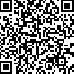

In [2]:
print(html_.decode('utf-8'))